In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src import constants as Con

from src.predictive_modeling.answer_correctness.answer_correctness_data import (
    build_trial_level_full_features_for_correctness,
)
from src.predictive_modeling.answer_correctness.answer_correctness_models import (
    MajorityBaselineCorrectness,
    AreaMetricsCorrectnessLogRegModel,
    DerivedFeaturesCorrectnessLogRegModel,
    FullFeaturesCorrectnessLogRegModel,
)
from src.predictive_modeling.answer_correctness.answer_correctness_eval import (
    evaluate_models_on_answer_correctness,
    evaluate_models_on_answer_correctness_leave_one_trial_out,
)
from src.predictive_modeling.answer_correctness.answer_correctness_viz import (
    plot_coef_summary_barh,
    show_correctness_model_results,
    plot_top_abs_coef_feature_frequency_across_participants,
    plot_top_features_by_best_avg_rank,
    compute_feature_avg_rank_across_participants,
)
from src.predictive_modeling.common.viz_utils import plot_confusion_heatmap

from src.predictive_modeling.answer_correctness.answer_correctness_participant_similarity import (
    build_participant_clustering_inputs,
    build_participant_family_clustering_inputs,
    default_feature_families,
)
from src.predictive_modeling.answer_correctness.answer_correctness_participant_cluster_metrics import (
    compute_distance_matrix,
    evaluate_k_range_silhouette,
    evaluate_k_range_davies_bouldin,
    cophenetic_correlation,
)
from src.predictive_modeling.answer_correctness.answer_correctness_participant_clusters_viz import (
    hierarchical_cluster_participants,
    plot_participant_dendrogram,
    compute_participant_umap,
    plot_participant_umap,
)
from src.predictive_modeling.answer_correctness.answer_correctness_participant_similarity_centroids import (
    compute_cluster_centroids,
    plot_cluster_centroids_barh,
)

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hunters = pd.read_csv("../data/hunters.csv")
gatherers = pd.read_csv("../data/gatherers.csv")
all_participants = pd.concat([hunters, gatherers], ignore_index=True)

In [3]:
from src.derived.pupil_norm import zscore_pupil_by_participant

pupil_cols = [
    Con.MEAN_AVG_FIX_PUPIL_SIZE,
    Con.MEAN_MAX_FIX_PUPIL_SIZE,
    Con.MEAN_MIN_FIX_PUPIL_SIZE,
    Con.FIRST_ENCOUNTER_AVG_PUPIL_SIZE
]
for col in pupil_cols:
    all_participants = zscore_pupil_by_participant(
        df=all_participants,
        pupil_col=col,
        participant_col=Con.PARTICIPANT_ID,
        stats_csv_path="../data/participant_pupils.csv",
        out_col=col,
    )

In [4]:
all_participants

,TRIAL_INDEX,participant_id,EYE_REPORTED,EYE_TRACKED,GROUPING_VARIABLES,IA_AREA,IA_AVERAGE_FIX_PUPIL_SIZE,IA_BOTTOM,IA_DWELL_TIME,IA_DWELL_TIME_%,...,mean_max_fix_pupil_size,mean_min_fix_pupil_size,mean_avg_fix_pupil_size,first_encounter_avg_pupil_size,last_area_visited_lbl,last_area_visited_loc,fix_by_label,fix_by_loc,simpl_fix_by_label,simpl_fix_by_loc
0,4,l42_2070,RIGHT,Right,RECORDING_SESSION,10165.0,.,261,0,0.0000,...,-0.132806,-0.132806,-0.132806,-0.132806,answer_C,answer_1(left),"['answer_B', 'answer_B', 'answer_B', 'answer_B...","['answer_0(top)', 'answer_0(top)', 'answer_0(t...","('question', 'answer_B', 'answer_D', 'answer_A...","('question', 'answer_0(top)', 'answer_2(right)..."
1,4,l42_2070,RIGHT,Right,RECORDING_SESSION,6099.0,1078.00,261,165,0.0280,...,-0.132806,-0.132806,-0.132806,-0.132806,answer_C,answer_1(left),"['answer_B', 'answer_B', 'answer_B', 'answer_B...","['answer_0(top)', 'answer_0(top)', 'answer_0(t...","('question', 'answer_B', 'answer_D', 'answer_A...","('question', 'answer_0(top)', 'answer_2(right)..."
2,4,l42_2070,RIGHT,Right,RECORDING_SESSION,14231.0,.,261,0,0.0000,...,-0.132806,-0.132806,-0.132806,-0.132806,answer_C,answer_1(left),"['answer_B', 'answer_B', 'answer_B', 'answer_B...","['answer_0(top)', 'answer_0(top)', 'answer_0(t...","('question', 'answer_B', 'answer_D', 'answer_A...","('question', 'answer_0(top)', 'answer_2(right)..."
3,4,l42_2070,RIGHT,Right,RECORDING_SESSION,28569.0,.,261,0,0.0000,...,-0.132806,-0.132806,-0.132806,-0.132806,answer_C,answer_1(left),"['answer_B', 'answer_B', 'answer_B', 'answer_B...","['answer_0(top)', 'answer_0(top)', 'answer_0(t...","('question', 'answer_B', 'answer_D', 'answer_A...","('question', 'answer_0(top)', 'answer_2(right)..."
4,4,l42_2070,RIGHT,Right,RECORDING_SESSION,4180.0,1139.00,492,184,0.0313,...,0.818597,-0.024968,0.402159,0.602773,answer_C,answer_1(left),"['answer_B', 'answer_B', 'answer_B', 'answer_B...","['answer_0(top)', 'answer_0(top)', 'answer_0(t...","('question', 'answer_B', 'answer_D', 'answer_A...","('question', 'answer_0(top)', 'answer_2(right)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760623,65,l2_324,LEFT,Left,RECORDING_SESSION,12535.0,.,1175,0,0.0000,...,0.200716,-0.015782,0.091049,0.735710,answer_A,answer_2(right),"['answer_B', 'answer_B', 'answer_B', 'answer_D...","['answer_0(top)', 'answer_0(top)', 'answer_0(t...","('question', 'answer_B', 'answer_D', 'answer_A...","('question', 'answer_0(top)', 'answer_1(left)'..."
760624,65,l2_324,LEFT,Left,RECORDING_SESSION,12768.0,.,1287,0,0.0000,...,0.200716,-0.015782,0.091049,0.735710,answer_A,answer_2(right),"['answer_B', 'answer_B', 'answer_B', 'answer_D...","['answer_0(top)', 'answer_0(top)', 'answer_0(t...","('question', 'answer_B', 'answer_D', 'answer_A...","('question', 'answer_0(top)', 'answer_1(left)'..."
760625,65,l2_324,LEFT,Left,RECORDING_SESSION,10640.0,921.00,1287,403,0.0736,...,0.200716,-0.015782,0.091049,0.735710,answer_A,answer_2(right),"['answer_B', 'answer_B', 'answer_B', 'answer_D...","['answer_0(top)', 'answer_0(top)', 'answer_0(t...","('question', 'answer_B', 'answer_D', 'answer_A...","('question', 'answer_0(top)', 'answer_1(left)'..."
760626,65,l2_324,LEFT,Left,RECORDING_SESSION,6384.0,921.00,1287,90,0.0164,...,0.200716,-0.015782,0.091049,0.735710,answer_A,answer_2(right),"['answer_B', 'answer_B', 'answer_B', 'answer_D...","['answer_0(top)', 'answer_0(top)', 'answer_0(t...","('question', 'answer_B', 'answer_D', 'answer_A...","('question', 'answer_0(top)', 'answer_1(left)'..."


In [8]:
correctness_models = [
    MajorityBaselineCorrectness(),
    AreaMetricsCorrectnessLogRegModel(),
    DerivedFeaturesCorrectnessLogRegModel(),
    FullFeaturesCorrectnessLogRegModel(),
]

pref_specs = [
    (Con.MEAN_DWELL_TIME, "high"),
    (Con.MEAN_FIXATIONS_COUNT, "high"),
    (Con.MEAN_FIRST_FIXATION_DURATION, "high"),
    (Con.SKIP_RATE, "low"),
    (Con.AREA_DWELL_PROPORTION, "high"),
    (Con.MEAN_AVG_FIX_PUPIL_SIZE, "high"),
    (Con.MEAN_MAX_FIX_PUPIL_SIZE, "high"),
    (Con.MEAN_MIN_FIX_PUPIL_SIZE, "low"),
    (Con.FIRST_ENCOUNTER_AVG_PUPIL_SIZE, "high"),
]

In [9]:
def build_trial_df(d: pd.DataFrame, group_cols):
    return build_trial_level_full_features_for_correctness(
        d,
        group_cols=group_cols,
        pref_specs=pref_specs,
    )

MODEL_NAME_FOR_ANALYSIS = "full_features_correctness_log_reg"

In [10]:
results_all_corr_full = evaluate_models_on_answer_correctness(
    df=all_participants,
    models=correctness_models,
    group_cols=(Con.PARTICIPANT_ID, Con.TRIAL_ID),
    split_group_cols=[Con.PARTICIPANT_ID, Con.TRIAL_ID],
    builder_fn=build_trial_df,
)

show_correctness_model_results(results_all_corr_full)

MODEL: majority_baseline
----------------------------------------------------------------------
Number of test trials: 3887
Accuracy: 0.836
Positive (correct) trials: 3249
Negative (incorrect) trials: 638

Precision / Recall / F1 (per class):
         precision  recall    f1  support
class_0      0.000   0.000 0.000      638
class_1      0.836   1.000 0.911     3249

Averages:
  macro   P/R/F1: 0.418 / 0.500 / 0.455
  weighted P/R/F1: 0.699 / 0.836 / 0.761

Confusion Matrix:
        pred_0  pred_1
true_0       0     638
true_1       0    3249

MODEL: area_metrics_correctness_log_reg
----------------------------------------------------------------------
Number of test trials: 3887
Accuracy: 0.768
Positive (correct) trials: 3249
Negative (incorrect) trials: 638

Precision / Recall / F1 (per class):
         precision  recall    f1  support
class_0      0.393   0.762 0.518      638
class_1      0.943   0.769 0.847     3249

Averages:
  macro   P/R/F1: 0.668 / 0.765 / 0.683
  weighted P/R/

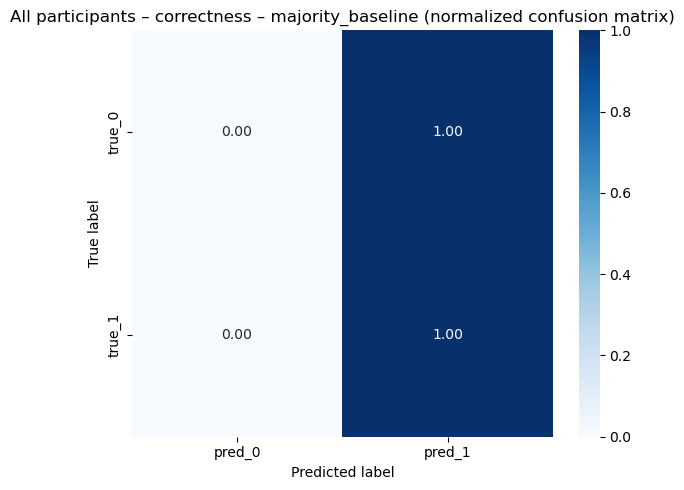

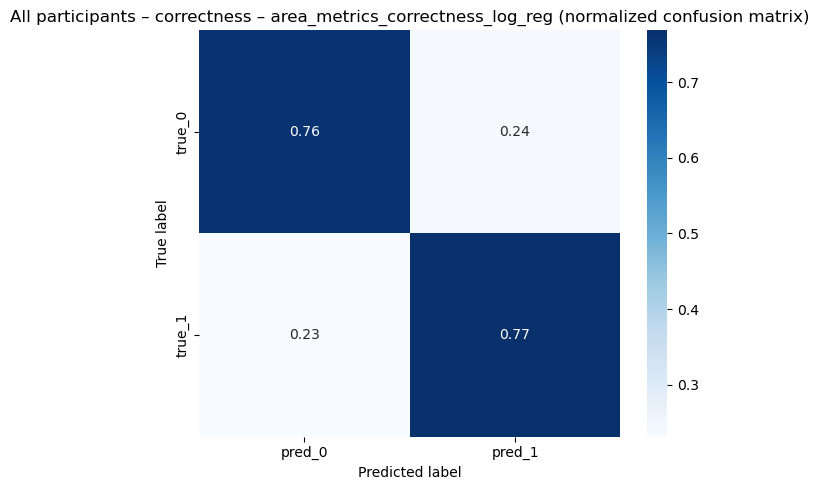

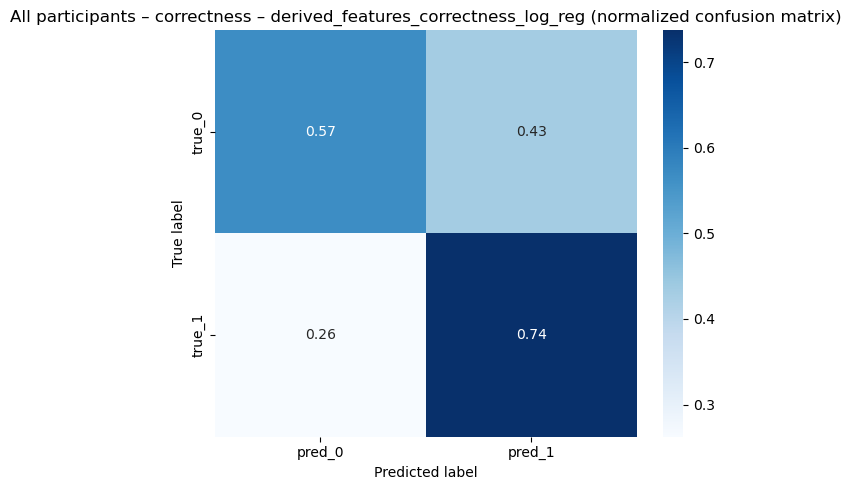

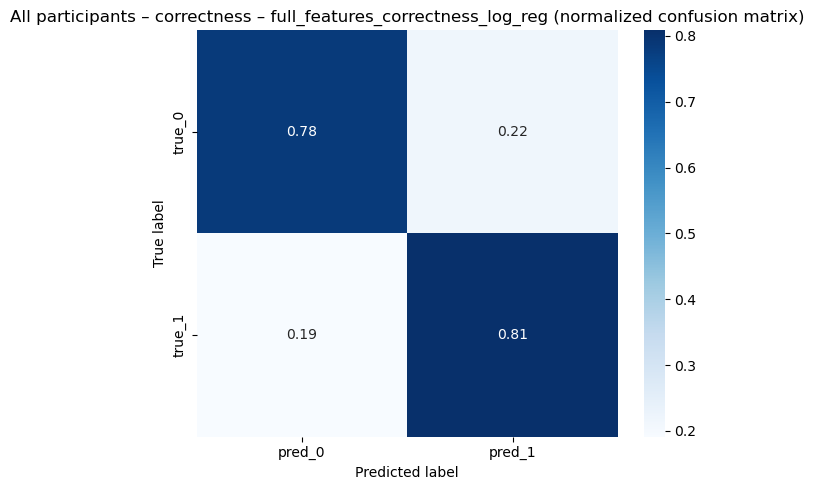

In [11]:
for name, res in results_all_corr_full.items():
    plot_confusion_heatmap(
        y_true=res.y_true,
        y_pred=res.y_pred,
        labels=(0, 1),
        include_minus1=False,
        normalize=True,
        title=f"All participants – correctness – {name} (normalized confusion matrix)",
    )

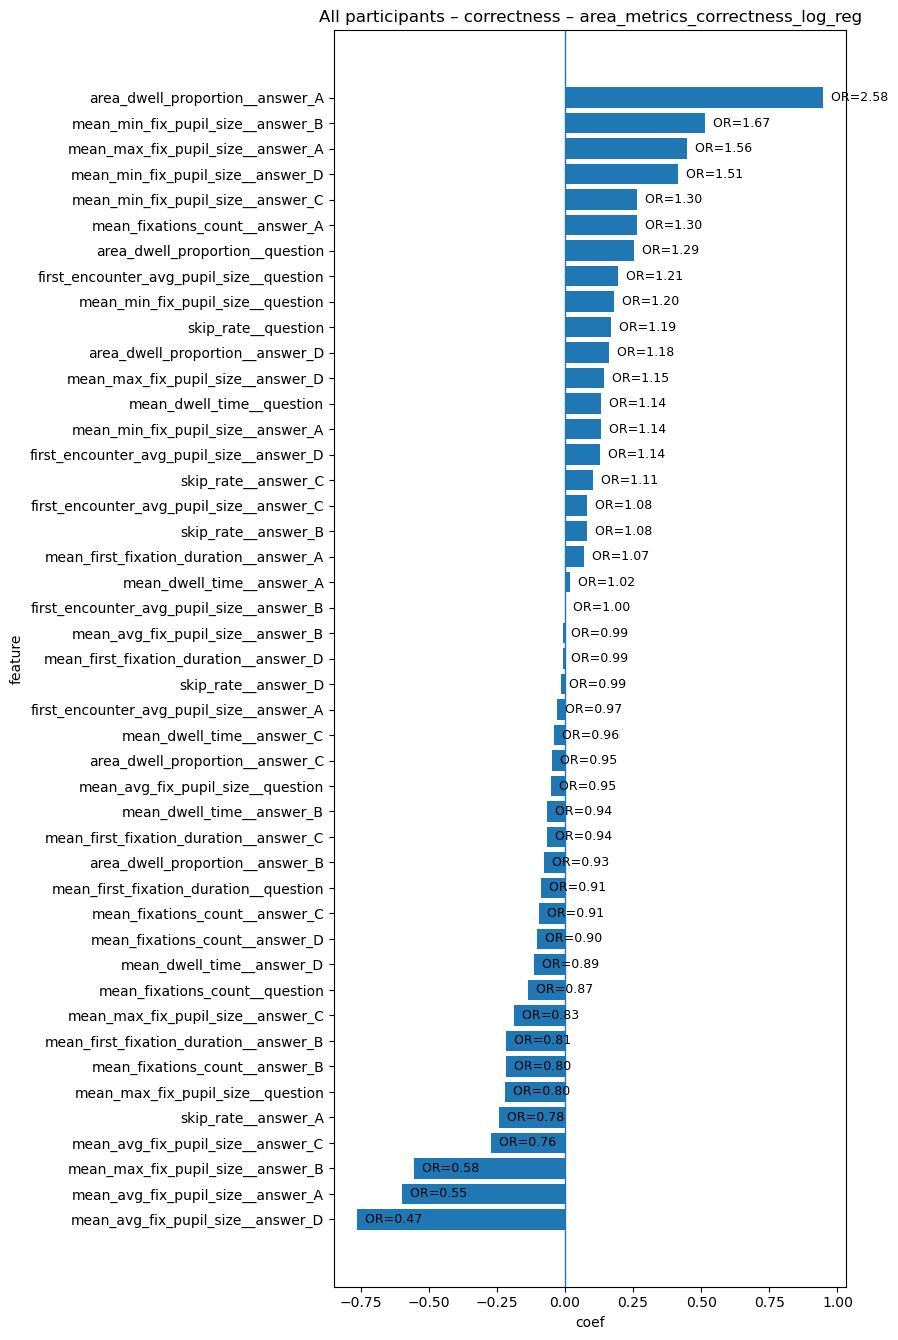

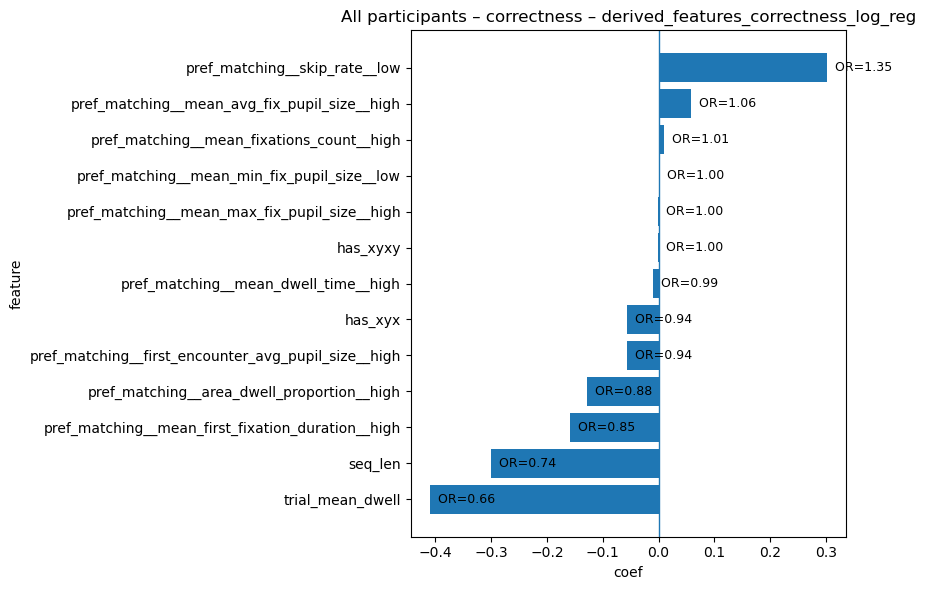

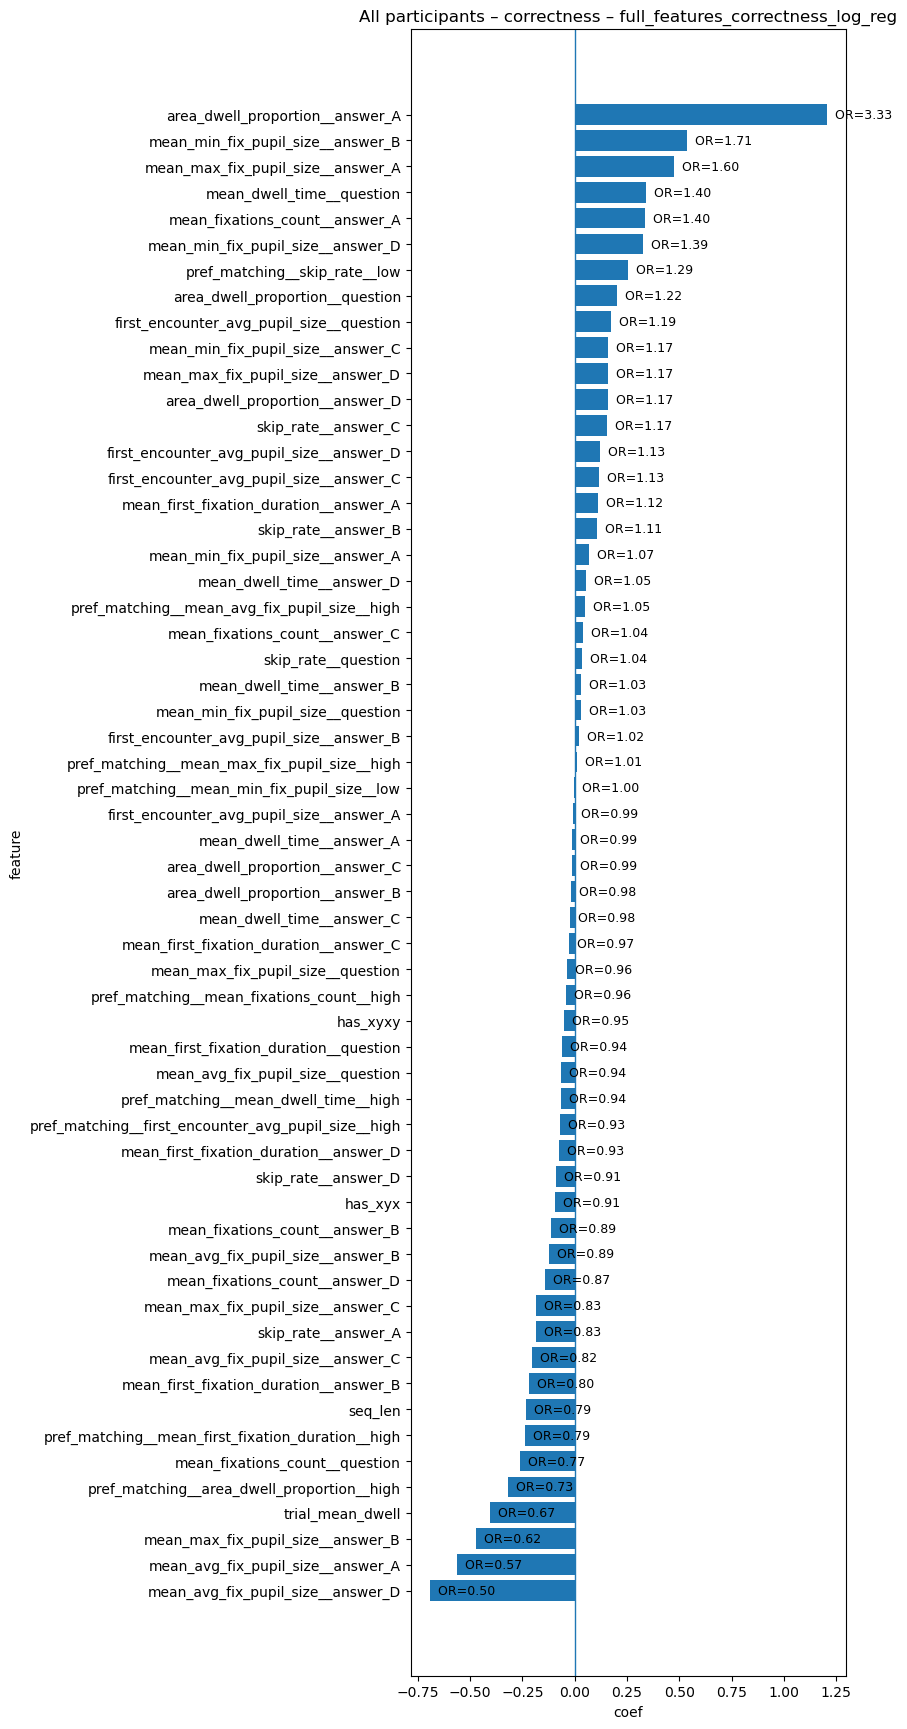

In [12]:
for model_name, res in results_all_corr_full.items():
    if res.coef_summary is None or res.coef_summary.empty:
        continue

    fig, _ = plot_coef_summary_barh(
        coef_summary=res.coef_summary,
        value_col="coef",
        model_name=model_name,
        title=f"All participants – correctness – {model_name}",
        save=True,
    )
    #new participant, new item
    # pupil z-score within participant -  from fixations.A current_pupil_size, find norm for each participant


In [13]:
results_by_pid = evaluate_models_on_answer_correctness_leave_one_trial_out(
    df=all_participants,
    models=correctness_models,
    group_cols=(Con.PARTICIPANT_ID, Con.TRIAL_ID),
    builder_fn=build_trial_df,
)

In [9]:
# base_out = "../reports/plots/participent_correctness_coeffs"
# for pid, per_model in results_by_pid.items():
#     for model_name, res in per_model.items():
#         if res.coef_summary is None or res.coef_summary.empty:
#             continue
#
#         save_path = os.path.join(base_out, model_name, f"{pid}.png")
#         os.makedirs(os.path.dirname(save_path), exist_ok=True)
#
#         fig, _ = plot_coef_summary_barh(
#             coef_summary=res.coef_summary,
#             value_col="coef",
#             model_name=model_name,
#             title=f"Participant {pid} – correctness – {model_name}",
#             save=True,
#             output_dir=os.path.dirname(save_path),  # uses its built-in filename unless you added save_path support
#         )
#         plt.close(fig)

,feature,count,n_pos,n_neg,n_zero,total_occ,prop,sign_varies,majority_sign,minority_count
25,mean_min_fix_pupil_size__answer_C,1,1,0,0,1,0.002809,False,1,0
26,mean_min_fix_pupil_size__answer_D,1,0,1,0,1,0.002809,False,-1,0
42,trial_mean_dwell,1,0,1,0,1,0.002809,False,-1,0
9,first_encounter_avg_pupil_size__question,1,1,0,0,1,0.002809,False,1,0
24,mean_min_fix_pupil_size__answer_A,2,0,2,0,2,0.005618,False,-1,0
6,first_encounter_avg_pupil_size__answer_B,2,2,0,0,2,0.005618,False,1,0
41,skip_rate__question,2,2,0,0,2,0.005618,False,1,0
15,mean_dwell_time__answer_D,2,1,1,0,2,0.005618,True,1,1
8,first_encounter_avg_pupil_size__answer_D,3,1,2,0,3,0.008427,True,-1,1
40,skip_rate__answer_D,3,2,1,0,3,0.008427,True,1,1


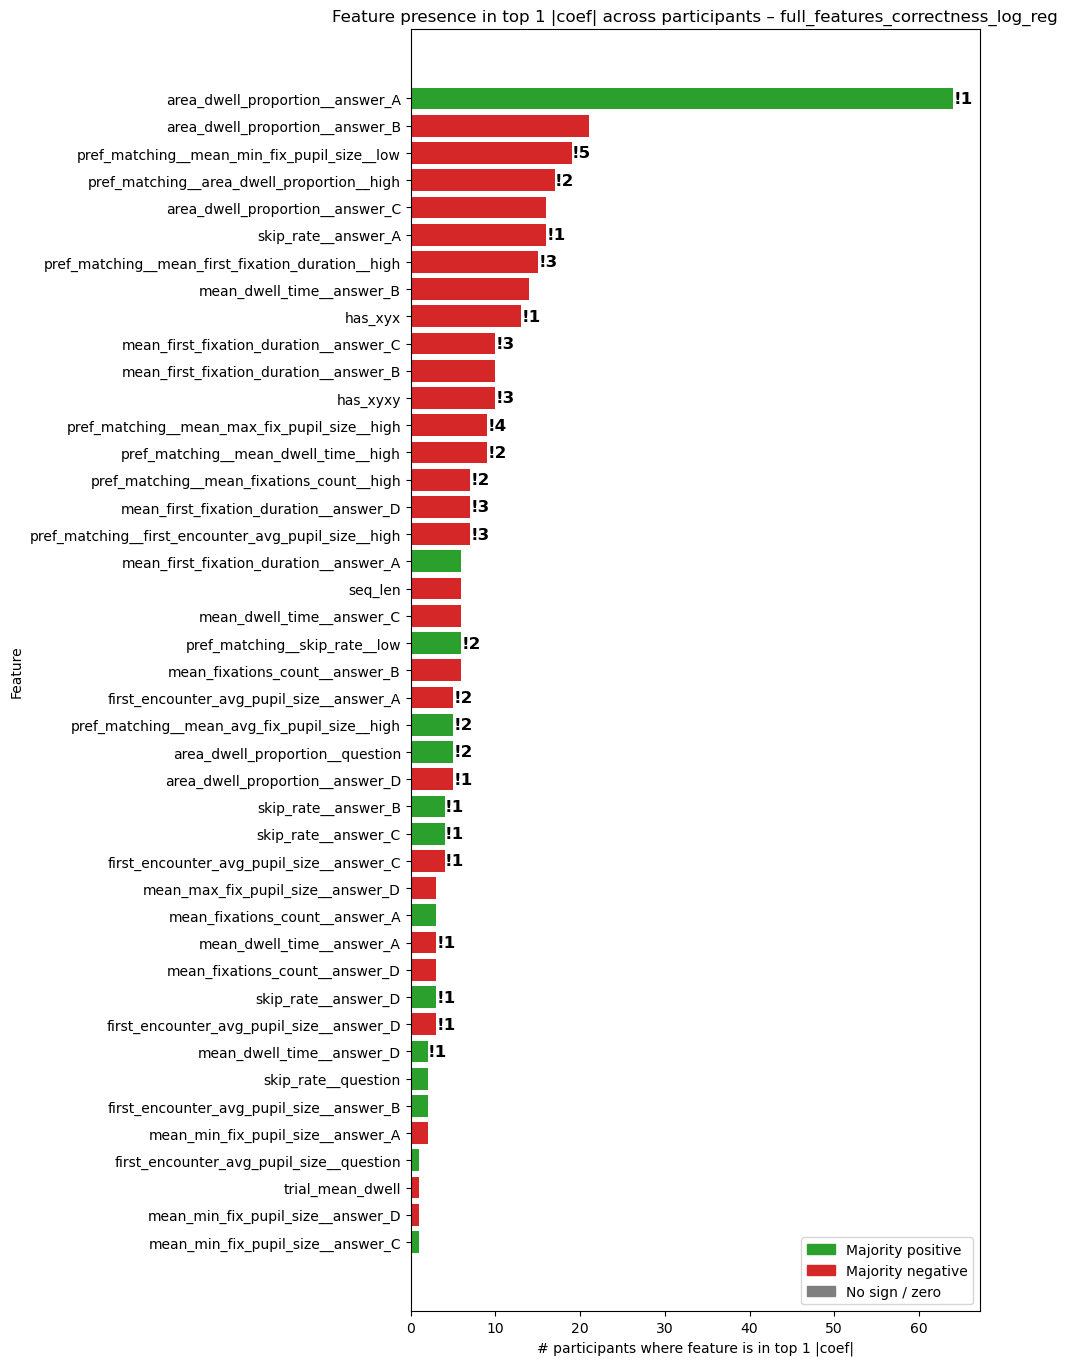

In [14]:
TOP_K_WITHIN_PARTICIPANT = 1
TOP_K_FEATURES_TO_SHOW = 70

fig, summary_df = plot_top_abs_coef_feature_frequency_across_participants(
    results_by_pid=results_by_pid,
    model_name=MODEL_NAME_FOR_ANALYSIS,
    coef_col="coef",
    top_k_within_participant=TOP_K_WITHIN_PARTICIPANT,
    top_k_features=TOP_K_FEATURES_TO_SHOW,
    save_path=f"../reports/plots/participent_correctness_coeffs/"
              f"top{TOP_K_WITHIN_PARTICIPANT}_presence_{MODEL_NAME_FOR_ANALYSIS}.png",
)
summary_df

,feature,count_participants,mean_rank,median_rank,std_rank,min_rank,max_rank
0,area_dwell_proportion__answer_A,356,12.235955,6.0,13.777731,1.0,57.0
1,area_dwell_proportion__answer_B,356,20.550562,16.0,17.305221,1.0,58.0
42,pref_matching__area_dwell_proportion__high,356,21.165730,17.0,16.697240,1.0,58.0
2,area_dwell_proportion__answer_C,356,22.480337,19.5,16.893941,1.0,58.0
52,skip_rate__answer_A,356,23.426966,19.0,16.997688,1.0,58.0
27,mean_fixations_count__answer_A,356,23.632022,20.0,15.620571,1.0,58.0
50,pref_matching__skip_rate__low,356,24.053371,21.0,16.465242,1.0,58.0
49,pref_matching__mean_min_fix_pupil_size__low,356,24.073034,21.0,17.165975,1.0,58.0
18,mean_dwell_time__answer_B,356,24.525281,20.0,17.655129,1.0,58.0
46,pref_matching__mean_first_fixation_duration__high,356,24.544944,21.0,17.371036,1.0,58.0


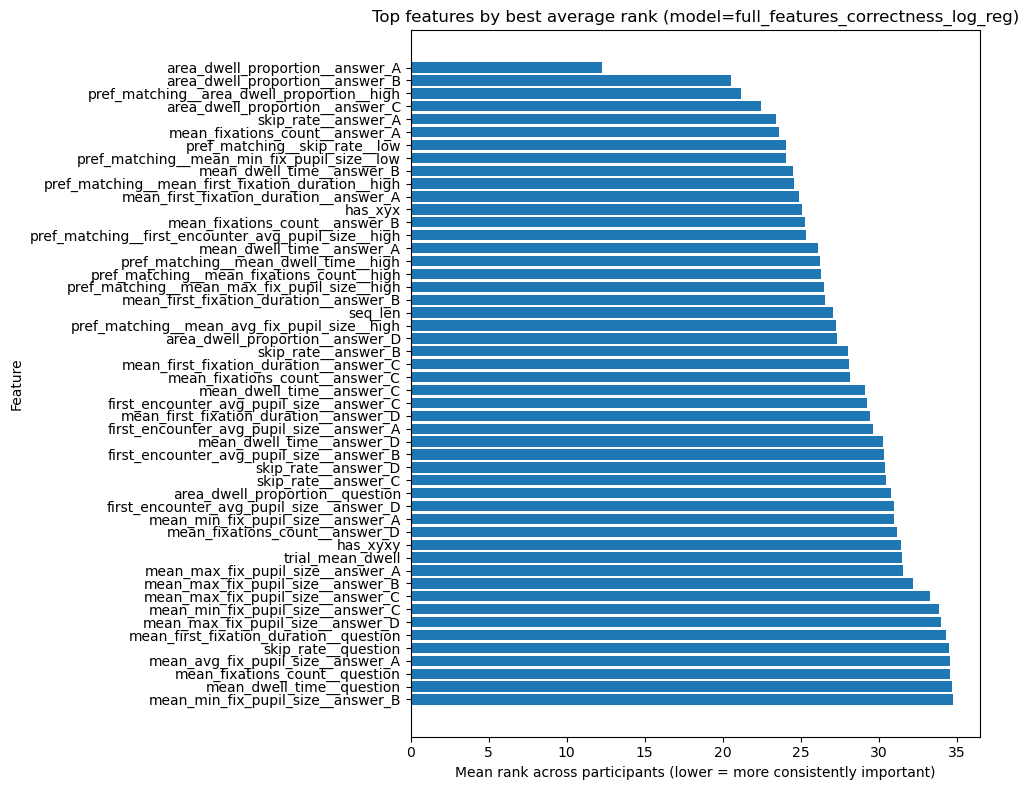

In [15]:
AVG_RANK_MIN_PARTICIPANTS = 1

avg_rank_df = compute_feature_avg_rank_across_participants(
    results_by_pid=results_by_pid,
    model_name=MODEL_NAME_FOR_ANALYSIS,
    coef_col="coef",
    abs_col="abs_coef",
)


fig = plot_top_features_by_best_avg_rank(
    avg_rank_df,
    top_k=50,
    min_participants=AVG_RANK_MIN_PARTICIPANTS,
    title=f"Top features by best average rank (model={MODEL_NAME_FOR_ANALYSIS})",
    save_path=f"../reports/plots/participent_correctness_coeffs/"
              f"top_mean_ranks_{MODEL_NAME_FOR_ANALYSIS}_minP{AVG_RANK_MIN_PARTICIPANTS}.png",
)

avg_rank_df.head(30)


In [22]:
def run_cluster_goodness_suite(
    X: pd.DataFrame,
    *,
    metric: str = "cosine",
    linkage_method: str = "average",
    k_range: range = range(2, 11),
):
    sil_df = evaluate_k_range_silhouette(
        X, distance_metric=metric, linkage_method=linkage_method, k_range=k_range
    )
    db_df = evaluate_k_range_davies_bouldin(
        X, linkage_method=linkage_method, k_range=k_range, normalize_rows_l2=True
    )
    D = compute_distance_matrix(X, metric=metric)
    coph = cophenetic_correlation(D, linkage_method=linkage_method)

    print(sil_df)
    print(db_df)
    print("cophenetic correlation:", coph)

    return sil_df, db_df, coph

    k  silhouette
0   2    0.058025
1   3    0.043209
2   4    0.045266
3   5    0.037159
4   6    0.033234
5   7    0.037490
6   8    0.042489
7   9    0.031868
8  10    0.024156
    k  davies_bouldin
0   2        4.835169
1   3        4.719077
2   4        4.272787
3   5        4.012711
4   6        3.938756
5   7        3.778165
6   8        3.722312
7   9        3.522915
8  10        3.373927
cophenetic correlation: 0.34210576920489316


C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


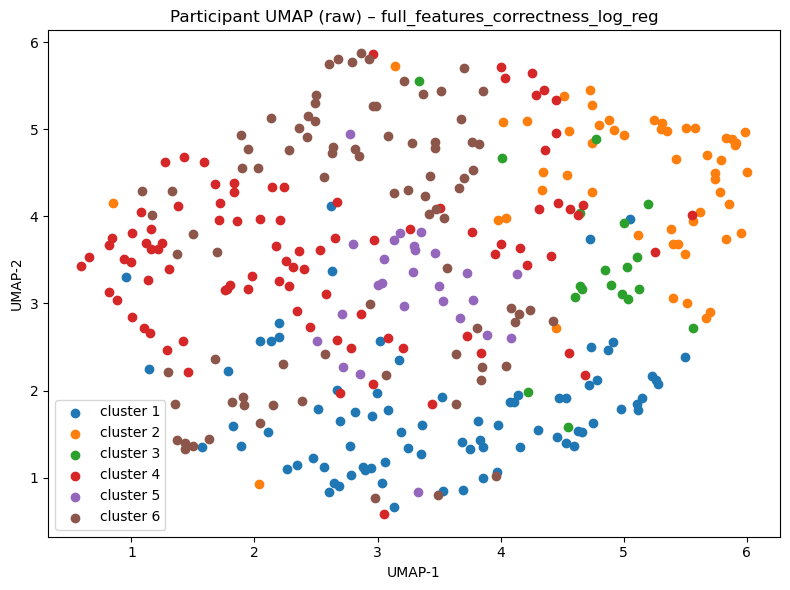

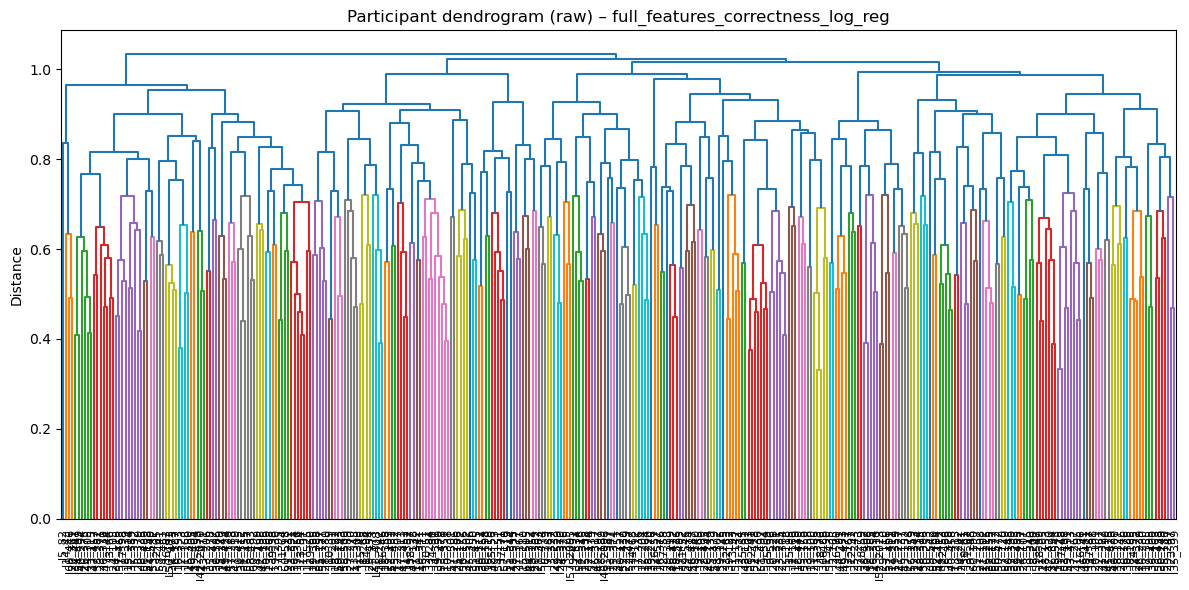

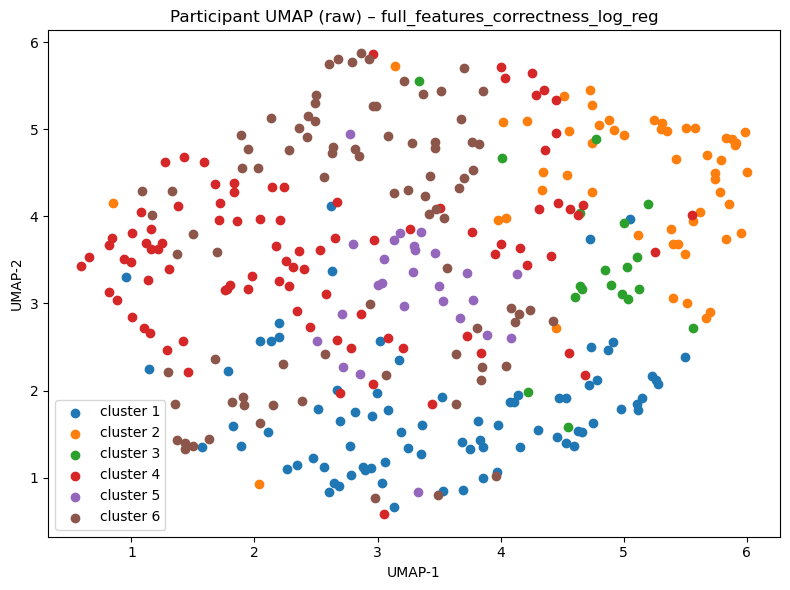

In [28]:
#  Participant similarity (raw coefficient vectors)
model_name = MODEL_NAME_FOR_ANALYSIS

inputs_raw = build_participant_clustering_inputs(
    results_by_pid=results_by_pid,
    model_name=model_name,
    coef_col="coef",
    zscore=True,
)

# --- goodness checks
run_cluster_goodness_suite(inputs_raw.coef_matrix_z)

# --- clustering + plots
D_raw = compute_distance_matrix(inputs_raw.coef_matrix_z, metric="cosine")
clust_raw = hierarchical_cluster_participants(
    D_raw, linkage_method="average", cut_mode="n_clusters", n_clusters=6
)

out_dir_raw = f"../reports/plots/participant_similarity/correctness/{model_name}/raw"
plot_participant_dendrogram(
    clust_raw,
    title=f"Participant dendrogram (raw) – {model_name}",
    save_path=os.path.join(out_dir_raw, "dendrogram.png"),
)

umap_xy_raw = compute_participant_umap(inputs_raw.coef_matrix_z, metric="cosine")
plot_participant_umap(
    umap_xy_raw,
    labels=clust_raw.labels,
    title=f"Participant UMAP (raw) – {model_name}",
    save_path=os.path.join(out_dir_raw, "umap.png"),
)

    k  silhouette
0   2    0.228932
1   3    0.199161
2   4    0.181994
3   5    0.197782
4   6    0.230167
5   7    0.228823
6   8    0.225447
7   9    0.225848
8  10    0.211142
    k  davies_bouldin
0   2        2.302750
1   3        2.134230
2   4        1.946254
3   5        1.810408
4   6        1.710369
5   7        1.645679
6   8        1.575191
7   9        1.510757
8  10        1.470923
cophenetic correlation: 0.5098347862118626


C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


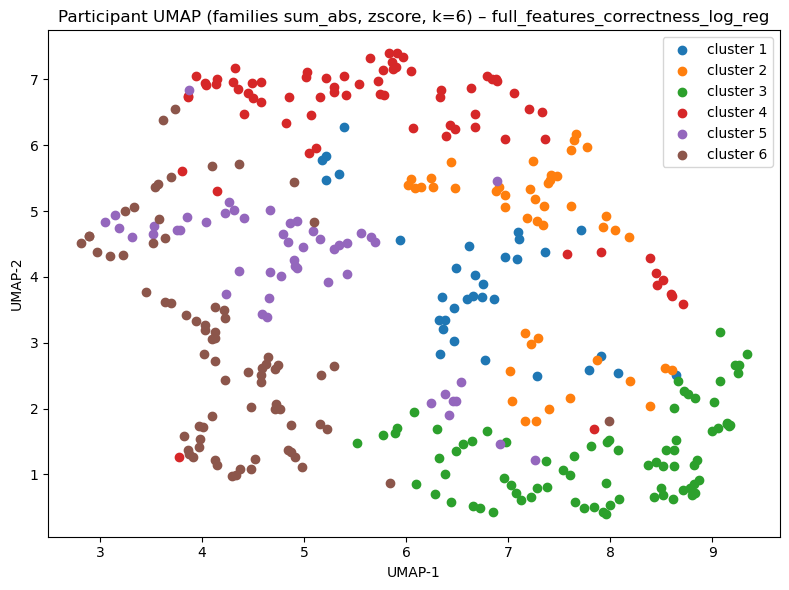

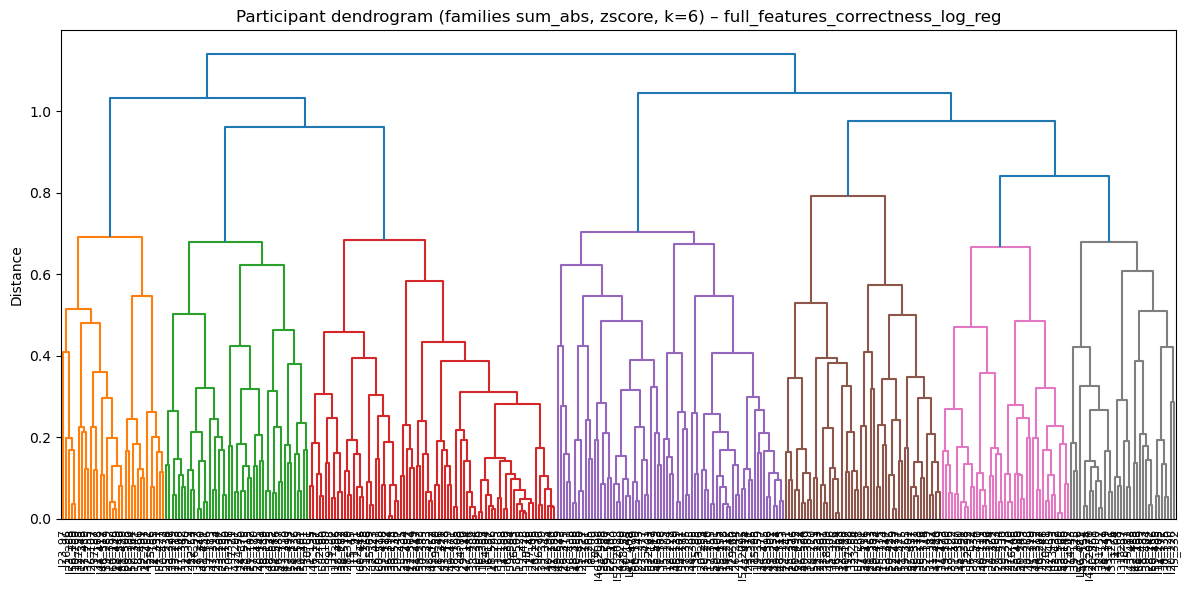

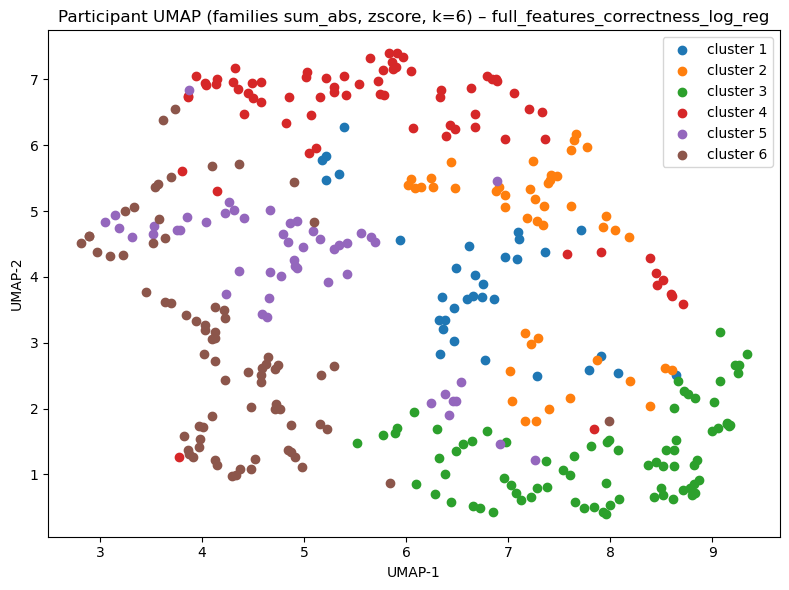

In [29]:
# Participant similarity (family-aggregated coefficient vectors)
fam_agg = "sum_abs"
zscore_flag = True
n_clusters = 6

z_tag = "zscore" if zscore_flag else "noz"
k_tag = f"k{n_clusters}"

fam_inputs = build_participant_family_clustering_inputs(
    results_by_pid=results_by_pid,
    model_name=model_name,
    coef_col="coef",
    families=default_feature_families(),
    family_agg=fam_agg,
    zscore=zscore_flag,
)

# --- goodness checks
run_cluster_goodness_suite(fam_inputs.coef_matrix_z)

# --- clustering + plots
D_fam = compute_distance_matrix(fam_inputs.coef_matrix_z, metric="cosine")

clust_fam = hierarchical_cluster_participants(
    D_fam,
    linkage_method="average",
    cut_mode="n_clusters",
    n_clusters=n_clusters,
)

out_dir_fam = (
    f"../reports/plots/participant_similarity/"
    f"correctness/{model_name}/"
    f"families_{fam_agg}_{z_tag}_{k_tag}"
)

os.makedirs(out_dir_fam, exist_ok=True)
plot_participant_dendrogram(
    clust_fam,
    title=(
        f"Participant dendrogram "
        f"(families {fam_agg}, {z_tag}, k={n_clusters}) – {model_name}"
    ),
    save_path=os.path.join(out_dir_fam, "dendrogram.png"),
)

umap_xy_fam = compute_participant_umap(
    fam_inputs.coef_matrix_z,
    metric="cosine",
)

plot_participant_umap(
    umap_xy_fam,
    labels=clust_fam.labels,
    title=(
        f"Participant UMAP "
        f"(families {fam_agg}, {z_tag}, k={n_clusters}) – {model_name}"
    ),
    save_path=os.path.join(out_dir_fam, "umap.png"),
)

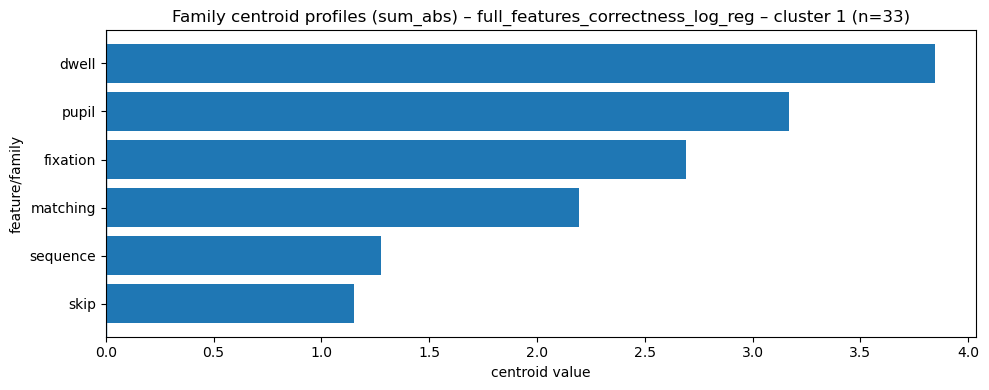

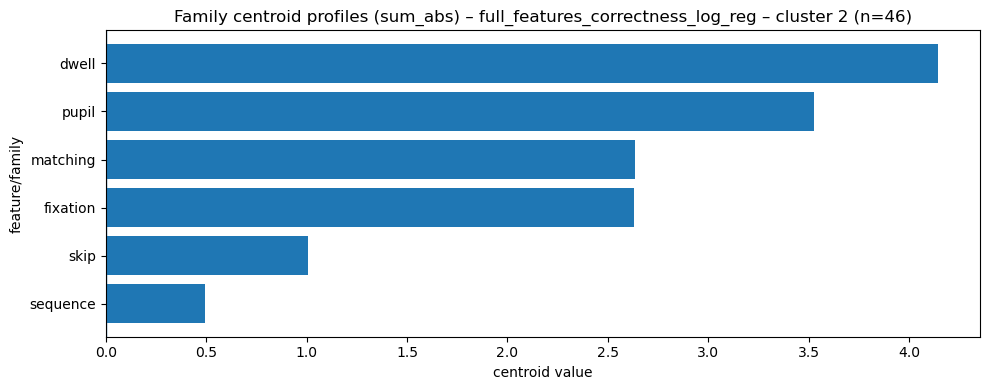

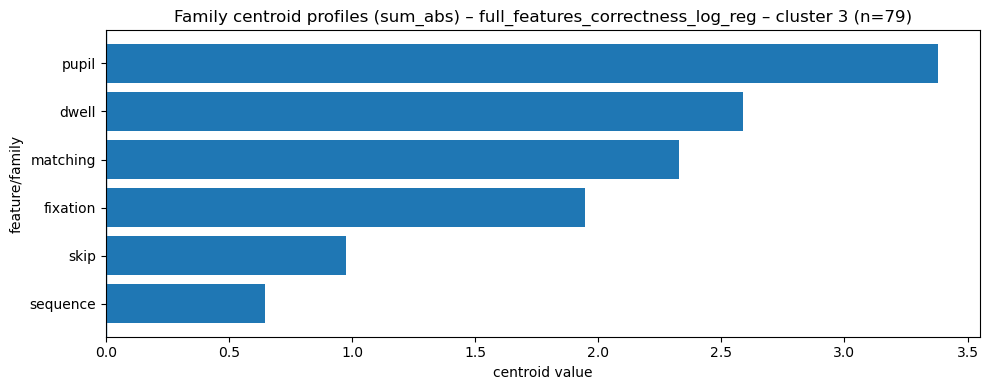

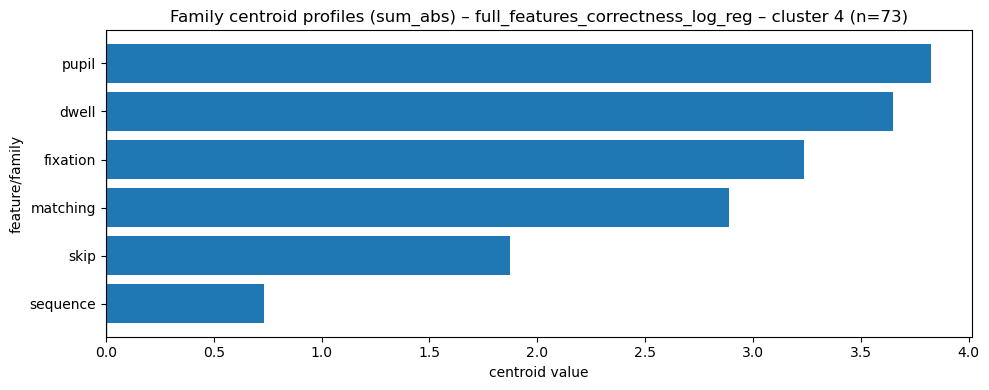

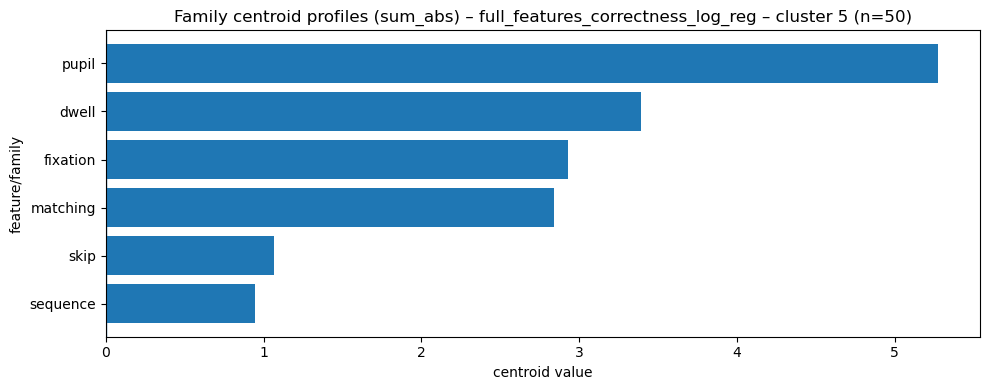

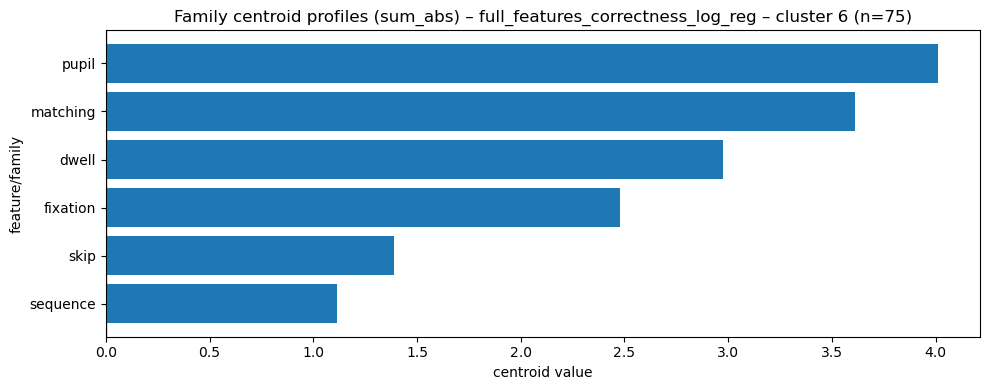

In [30]:
X_fam = fam_inputs.coef_matrix

cent_res = compute_cluster_centroids(
    X=X_fam,
    labels=clust_fam.labels,
    agg="mean",
    top_k=10,
)

# # Save centroid tables for inspection
# cent_res.centroids.to_csv(os.path.join(out_dir_fam, "cluster_centroids.csv"))
# cent_res.counts.to_csv(os.path.join(out_dir_fam, "cluster_sizes.csv"))
# cent_res.top_features.to_csv(os.path.join(out_dir_fam, "cluster_top_features.csv"), index=False)

# Plot one centroid bar chart per cluster
plot_cluster_centroids_barh(
    centroids=cent_res.centroids,
    counts=cent_res.counts,
    top_k=12,
    title=f"Family centroid profiles ({fam_agg}) – {MODEL_NAME_FOR_ANALYSIS}",
    save_path=os.path.join(out_dir_fam, "centroid_cluster{cluster}.png"),
)

In [ ]:
#beep boop